# The purpose of this application is to produce Ternary scatter graphs regarding rock and mineral geochemical data. 

**Copy data from Google Drive to Colaboratory**

https://www.mikulskibartosz.name/how-to-load-data-from-google-drive-to-pandas-running-in-google-colaboratory/

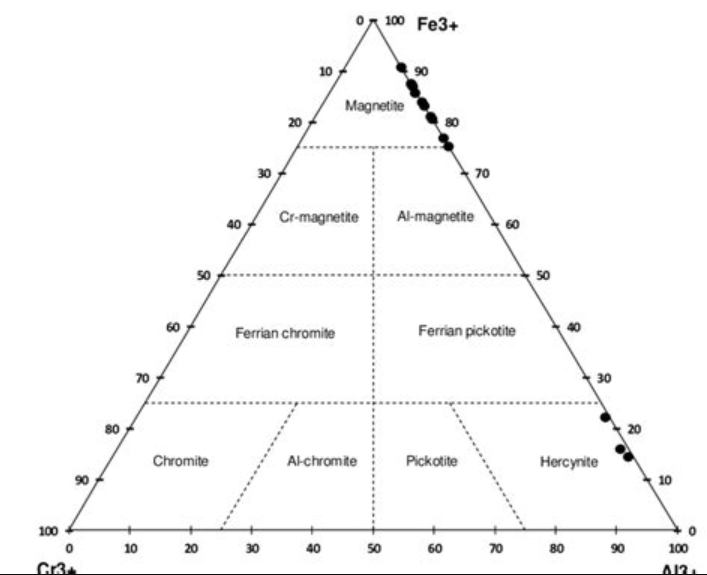

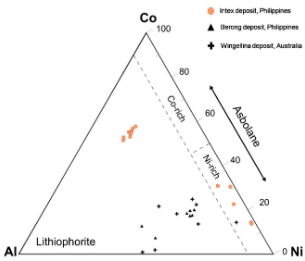

In [ ]:
### LIBRARIES ###

import pandas as pd
import numpy as np

'''What does it do? Imports libraries that allow us to access 
Google Drive and allows the Google Cloud SDK 
to access the Google Drive of the currently logged in user. 
As a result, you can access your files from python code running in Colaboratory.'''

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def connect_directory(search, path):
  '''
  it is not so easy to find the identifier of a file. To find such identifier, 
  we must list the files in the directory: The code prints names and identifiers 
  of the files in the directory. Copy the identifier of the file you want to open. 
  You are going to need it.
  e.g. if your directory is: 
  'https://drive.google.com/drive/u/1/folders/1FdRHCwSGudmhed5hdtIgL0bdk36XmOnR', 
  so your path is '1FdRHCwSGudmhed5hdtIgL0bdk36XmOnR', paste on the following script
  '''

  listed = drive.ListFile({'q': f"title contains '{search}' and '{path}' in parents"}).GetList()
  for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))

  '''the output is the path of the file itself, so you must get it, as well as get 
  the full name of the file, wich includes the extension (like .xlsx)'''

In [ ]:
'''First of all, let’s create a local directory to store a copy of the file:'''

download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

def database(filename, fileid): 
  '''Now we have the file id and the output directory. We can copy the file from Google Drive:'''

  output_file = os.path.join(download_path, f'{filename}')
  temp_file = drive.CreateFile({'id': f'{fileid}'})
  temp_file.GetContentFile(output_file)

  xls = pd.ExcelFile(output_file)
  print(xls.sheet_names)
  sheet = input('load sheet: ')

  return pd.read_excel(output_file, sheet_name = sheet)

In [ ]:
# SETTING VARIABLES FOR TERNARY
def ternary_coord(data_tab):
  print(data_tab[0:0])
  global xaxis, yaxis, zaxis
  xaxis = input('x axis: ')
  yaxis = input('y axis: ')
  zaxis = input('z axis: ')

  x = list(data_tab[xaxis])
  y = list(data_tab[yaxis])
  z = list(data_tab[zaxis])

  for header, i in enumerate([x,y,z]):
    print(i[:5])
  return x, y, z

In [ ]:
def unique(dbcolumn):
  '''# CHECK UNIQUE VALUES OF A COLUMN #'''
  print(set(dbcolumn))

In [ ]:

def normalization(x,y,z):
    '''data transformation to ternary'''
    sum_norm = []
    x_norm = []
    y_norm = []
    z_norm = []

    for i in range(0, len(x)):
      sum_norm.append(x[i] + y[i] + z[i])

    for i in range(0, len(x)):
      x_norm.append(x[i]/sum_norm[i])

    for i in range(0, len(y)):
      y_norm.append(y[i]/sum_norm[i])

    for i in range(0, len(z)):
      z_norm.append(z[i]/sum_norm[i])

    return x_norm, y_norm, z_norm

    #print(x[0], y[0],  z[0], sum_norm[0])


In [ ]:
def ternary_plot(x, y, z, color = None, non_num = None, discrete_colors = {}, barvar = None, cmapcolor = None, label = False, grid = False, fields = None, frame = (10,10)):
  ''' 
  ternary plot, first of all, normalizes the 3D coordinates, and 
  re-normalizes x,y coordinates between themselves
  so, it passes the normalized data as (X,Y) coordinates to be plotted 
  within a triangle
  
  color:  a unique color for every data

  non_num:  a non-numeric variable that can be classified by a discrete list 
            of colors

  discrete_colors:  a dictionary that carries each unique value of 
                    non_num *arg with its respective color
  
  barvar: the column(var) that goes on the continuous colorbar
            e.g., a fourth element

  cmapcolor:  cmap pattern ('viridis', 'plasma', 'inferno', 'magma', 'cividis', 
              'jet', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
              'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
              'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper')

  label:  which column data to be plotted as a label por point

  grid: default = False

  fields: 'chromite' for chromite classification ternary (Cr, Al, Fe)
          'asbolane' for asbolane-lithiphorite ternary (Al, Ni, Co)
  '''
  ### DEFINING NORMALIZATION FUNC ###
  def normalization(x,y,z):
      sum_norm = []
      x_norm = []
      y_norm = []
      z_norm = []

      for i in range(0, len(x)):
        sum_norm.append(x[i] + y[i] + z[i])

      for i in range(0, len(x)):
        x_norm.append(x[i]/sum_norm[i])
        y_norm.append(y[i]/sum_norm[i])
        z_norm.append(z[i]/sum_norm[i])
      return x_norm, y_norm, z_norm

      #print(x[0], y[0],  z[0], sum_norm[0])

  import matplotlib.pyplot as plt
  import matplotlib.lines as lines
  
  ### NORMALIZATION OF 3D COORDINATES ###
  x_norm, y_norm, z_norm = normalization(x,y,z)
  
  ### 3D to 2D coordinates ###
  X = []
  Y = []
  X.clear()
  Y.clear()
  for i in range(0,len(z_norm)):
    Y.append(z_norm[i])

  for i in range(0, len(x_norm)):
    X.append(((y_norm[i]/(x_norm[i] + y_norm[i])) * (1-Y[i])) + 0.5*Y[i])
      ## normalizing x n y again for the X axis, multiply for the complement of Y axis to adjust to triangle, so add a displacement proportional to Y

  ### setting some ternary ploting configs like ternaty height h 
  h = (((3**(1/2)))/(2))+0.012

  print(h)

  ### PLOT SIZE ###
  if cmapcolor != None:
    fig = plt.figure(figsize =(frame[0]+2,frame[1]*h))
    fig, ax = plt.subplots(1, figsize =(frame[0]+2,frame[1]*h))
  else:
    fig = plt.figure(figsize =(frame[0],frame[1]*h))
    fig, ax = plt.subplots(1, figsize =(frame[0],frame[1]*h))
  
  ### TERNARY BOARDER ###
  triangle = ((0.0, 0.5, 1, 0), (0.001, 1, 0.001, 0.001))
  ax.plot(triangle[0],triangle[1], '-', color = 'black', linewidth = '1.2')

  ### TERNARY GRID ###
  if grid == True:
    grid = {'hgrid' : ((0.05, 0.95, 0.9, 0.1, 0.15, 0.85, 0.8, 0.2, 0.25, 0.75, 0.7, 0.3, 0.35, 0.65, 0.6, 0.4, 0.45, 0.55),
                    (0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9)),
            'xgrid' : ((0.05, 0.1, 0.2, 0.1, 0.15, 0.3, 0.4, 0.2, 0.25, 0.5, 0.6, 0.3, 0.35, 0.7, 0.8, 0.4, 0.45, 0.9, 1),
                    (0.1, 0, 0, 0.2, 0.3, 0, 0, 0.4, 0.5, 0, 0, 0.6, 0.7, 0, 0, 0.8, 0.9, 0, 0)),
            'ygrid' : ((0.1, 0.55, 0.6, 0.2, 0.3, 0.65, 0.7, 0.4, 0.5, 0.75, 0.8, 0.6, 0.7, 0.85, 0.9, 0.8, 0.9, 0.95),
                    (0, 0.9, 0.8, 0, 0, 0.7, 0.6, 0, 0, 0.5, 0.4, 0, 0, 0.3, 0.2, 0, 0, 0.1))}
    for i in grid.keys():
      ax.plot(grid[i][0], grid[i][1], '-',color = 'black', linewidth = '0.2', alpha = 0.5)

  ### CHROMITE FIELDS ###

  if fields == 'chromite':
    hfields = ((0.125, 0.875, 0.75, 0.25, 0.375, 0.625),
              (0.25, 0.25, 0.5, 0.5, 0.75, 0.75))
    ax.plot(hfields[0], hfields[1], '--',color = 'black', alpha = 0.7, linewidth = '1')

    vfields = ((0.25, 0.375, 0.625, 0.75, 0.5, 0.5),
              (0, 0.25, 0.25, 0, 0, 0.75))
    ax.plot(vfields[0], vfields[1], '--',color = 'black', alpha = 0.7, linewidth = '1')
    
    field_label = (('Magnetite', 'Cr-magnetite', 'Al-magnetite', 'Ferrian chromite', 'Ferrian pickotite', 'Pickotite', 'Hercynite', 'Chromite', 'Al-chromite'),
                   (0.5, 0.4, 0.6, 0.37, 0.63, 0.6, 0.82, 0.18, 0.4),
                   (0.85, 0.6, 0.6, 0.4, 0.4, 0.1, 0.1, 0.1, 0.1,))

    for i, l in enumerate(field_label[0]):
        ax.annotate(l, xy=(field_label[1][i], field_label[2][i]), xytext=(field_label[1][i], field_label[2][i]),
                  arrowprops=None, ha='center', va='center', rotation= 0, size=12)
        
  ### ASBOLANE-LITHIOPHORITE FIELDS ###

  if fields == 'asbolane':
    asbolane = ((0.45, 0.9, 1, 0.75, 0.675), (0.9, 0, 0,0.5, 0.45))
    ax.plot(asbolane[0], asbolane[1], '-',color = 'black', linewidth = '1')

    ax.annotate('Lithiophorite', xy=(0.08, 0.05), xytext=(0.3, 0.2),
                arrowprops=dict(arrowstyle='->'), ha='center', va='center', rotation= 0, size=15)
    ax.annotate('Co-rich', xy=(0.6, 0.7), xytext=(0.6, 0.7),
                arrowprops=None, ha='center', va='center', rotation= -60, size=15)
    ax.annotate('Ni-rich', xy=(0.83, 0.24), xytext=(0.83, 0.24),
                arrowprops=None, ha='center', va='center', rotation= -60, size=15)
    ax.annotate('Asbolane', xy=(0.925, 0.24), xytext=(0.78, 0.53),
                arrowprops=None, ha='center', va='center', rotation= -60, size=15)
    
  ### MG SILICATES FIELDS ###

  if fields == 'mgsilicates':
    mgsilicates = ((0.875, 0.215, 0.305, 0.81, 0.8, 0.315), (0.25, 0.43, 0.61, 0.38, 0.4, 0.635))
    ax.plot(mgsilicates[0], mgsilicates[1], '--',color = 'black', linewidth = '1')

    ax.annotate('serpentine series', xy=(0.08, 0.05), xytext=(0.23, 0.425),
                arrowprops=None, ha='left', va='center', rotation= -13, size=8)
    ax.annotate('talc series', xy=(0.08, 0.05), xytext=(0.31, 0.575),
                arrowprops=None, ha='left', va='center', rotation= -21, size=8)
    ax.annotate('sepiolite series', xy=(0.08, 0.05), xytext=(0.33, 0.62),
                arrowprops=None, ha='left', va='center', rotation= -22, size=8)


  # points label #
  if bool(label) == True:
    annotations = label
    for i, label in enumerate(annotations):
        plt.annotate(label, (0.02 + X[i], 0.02 + Y[i]), fontsize = 14, weight = 'normal')

  ### CONFIG ###
  plt.ylim(0, 1)
  plt.xlim(0, 1)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.axis('off')  # command for hiding the axis.


  ### ANNOTATE ###
  # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html
  # annotate axis labels #
  axis_label = ((xaxis, yaxis, zaxis),
                (0, 1, 0.5),
                (-0.04, -0.04, 1.035))

  for i, l in enumerate(axis_label[0]):
    ax.annotate(l, xy=(axis_label[1][i], axis_label[2][i]), xytext=(axis_label[1][i], axis_label[2][i]),
              arrowprops=None, ha='center', va='center', rotation= 0, size=20, annotation_clip = False)

  ### PLOT ###
  if color != None:
    plt.scatter(X, Y, s = 120, alpha = 1, c = color, edgecolors = 'black')

  elif type(non_num) != type(None):
    plt.scatter(X, Y, s = 120, alpha = 1, c = non_num.map(discrete_colors), edgecolors = 'black')
    plt.legend(non_num.map(discrete_colors), discrete_colors.keys(), loc ="upper left")
    ax.annotate(discrete_colors, xy=(0.2, 0.9), xytext=(0.2, 0.9),
                arrowprops=None, ha='center', va='center', rotation= 0, size=12)

  elif cmapcolor != None:
    plt.scatter(X, Y, s = 120, alpha = 1, c = list(barvar), cmap = cmapcolor , edgecolors = 'black') # 'inferno' 'jet'
    cb = plt.colorbar()
    cb.set_label(barvar.name, color= 'black', fontsize = 18)

  else: plt.scatter(X, Y, s = 120, alpha = 1, c = 'black', edgecolors = 'black')

  ### SAVE FIG ###
  save_fig = input('save? (y/n)')
  if save_fig == 'y':
    fname = input('file name: ')
    plt.savefig(f'{fname}.png', transparent=False)
    files.download(f'{fname}.png')
  else: pass

  plt.show()


In [ ]:
connect_directory('Analises', '1FdRHCwSGudmhed5hdtIgL0bdk36XmOnR')

title Analises_MEV-EDS_Vivian.xlsx, id 1peP0weD0fhN7nraNBucm9egXp50a5OFf


In [ ]:
BADB = database('Analises_MEV-EDS_Vivian.xlsx', '1peP0weD0fhN7nraNBucm9egXp50a5OFf')
print(BADB.head())
Cr, Al, Fe = ternary_coord(BADB)
unique(BADB['source'])

['CHROMITE', 'ASBOLANE-LITHIOPHORITE']
load sheet: CHROMITE
  source         size   mineral  id        Mg        Al        Si   Cl  \
0   BC-2  0.25x0.18mm       NaN  43  4.601857  9.763667  0.000000  0.0   
1   BC-2  0.25x0.18mm       NaN  40  3.993701  9.586962  0.000000  0.0   
2   BC-2  0.25x0.18mm       NaN  25  3.540980  8.730974  0.162351  0.0   
3   BC-2  0.25x0.18mm  chromite  13  3.200774  7.312557  0.040767  0.0   
4   BC-2  0.25x0.18mm  chromite   6  2.759699  6.653342  0.000000  0.0   

         Ti         V         Cr   Mn         Fe   Ni        Zn        Sum  
0  0.000000  0.148727  33.392928  0.0  15.419069  0.0  0.201223  94.929486  
1  0.111378  0.230603  25.275826  0.0  23.365397  0.0  0.000000  91.993863  
2  0.000000  0.209389  30.909834  0.0  17.386399  0.0  0.000000  90.125137  
3  0.000000  0.087267  33.295562  0.0  16.350805  0.0  0.421580  88.950285  
4  0.107094  0.170303  36.822806  0.0  17.790114  0.0  0.000000  94.341016  
Empty DataFrame
Columns: [source,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:174: UserWarning: Legend does not support 'red' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


0.8780254037844386
save? (y/n)y
file name: chr_classif_bygroup


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1008x885.05 with 0 Axes>

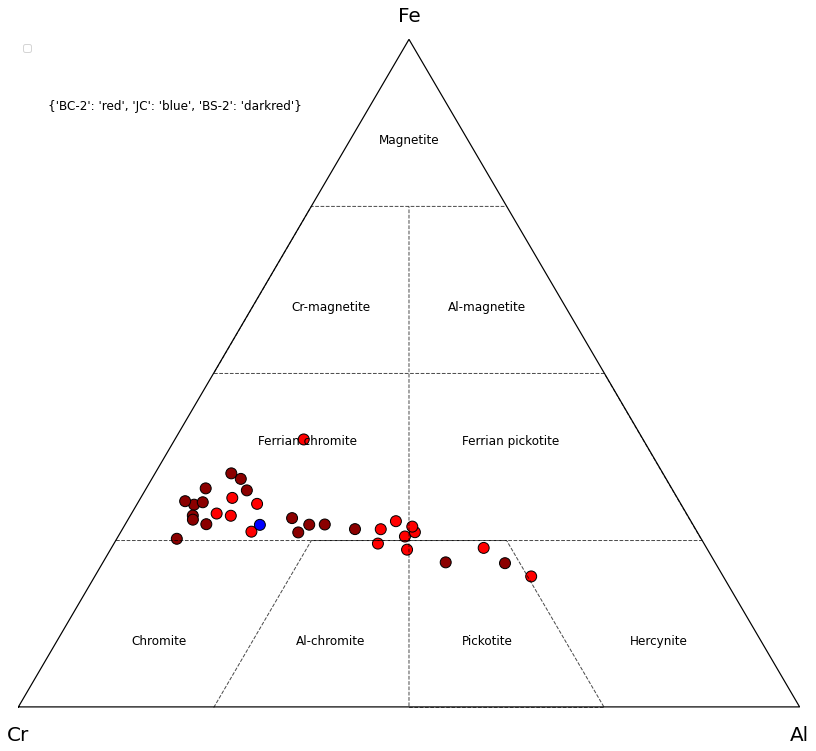

In [ ]:
legenda = {'BC-2': 'red', 'JC': 'blue', 'BS-2': 'darkred'}
ternary_plot(Cr, Al, Fe, 
             non_num = BADB['source'], 
             discrete_colors=legenda, 
             fields = 'chromite', 
             frame = (14,14))

0.8780254037844386
save? (y/n)y
file name: chr_classif_byMg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1152x885.05 with 0 Axes>

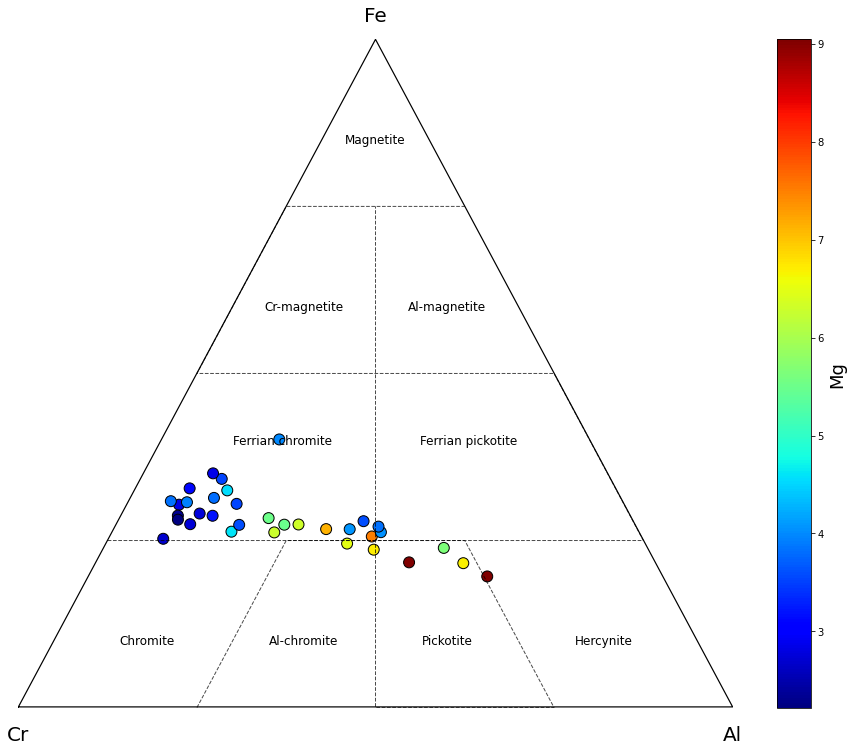

In [ ]:
ternary_plot(Cr, Al, Fe, 
             barvar=BADB['Mg'], 
             cmapcolor='jet', 
             fields = 'chromite',
             frame= (14,14))

In [ ]:
BADB_asb = database('Analises_MEV-EDS_Vivian.xlsx', '1peP0weD0fhN7nraNBucm9egXp50a5OFf')
print(BADB_asb.head())
Al_, Ni, Co = ternary_coord(BADB_asb)
unique(BADB_asb['source'])

['CHROMITE', 'ASBOLANE-LITHIOPHORITE']
load sheet: ASBOLANE-LITHIOPHORITE
  source         size                 mineral  id        Si        Al  \
0   BC-2  0.25x0.18mm  Asbolane-lithiophorite  10  0.810671  6.844873   
1   BC-2  0.25x0.18mm  Asbolane-lithiophorite  11  0.851004  6.345130   
2   BC-2  0.25x0.18mm                asbolane  16  0.735492  2.154758   
3   BC-2  0.25x0.18mm                asbolane  17  0.842905  2.113092   
4   BC-2  0.25x0.18mm                asbolane  18  1.409797  2.550828   

         Ca   Ti        Cr         Mn        Fe        Co         Ni   Cu  \
0  0.224166  0.0  0.567581  27.441844  5.928850  9.834964  11.849223  0.0   
1  0.083514  0.0  0.427818  20.355941  5.360418  6.778834   7.631529  0.0   
2  0.158018  0.0  0.000000  24.203991  6.674223  4.259671  14.562529  0.0   
3  0.140960  0.0  0.000000  24.604785  6.303917  4.285914  15.405966  0.0   
4  0.000000  0.0  0.000000  22.828527  6.540929  4.427444  13.996719  0.0   

    Zn   Ba        Sum  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: UserWarning: Legend does not support 'red' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


0.8780254037844386
save? (y/n)n


<Figure size 1008x885.05 with 0 Axes>

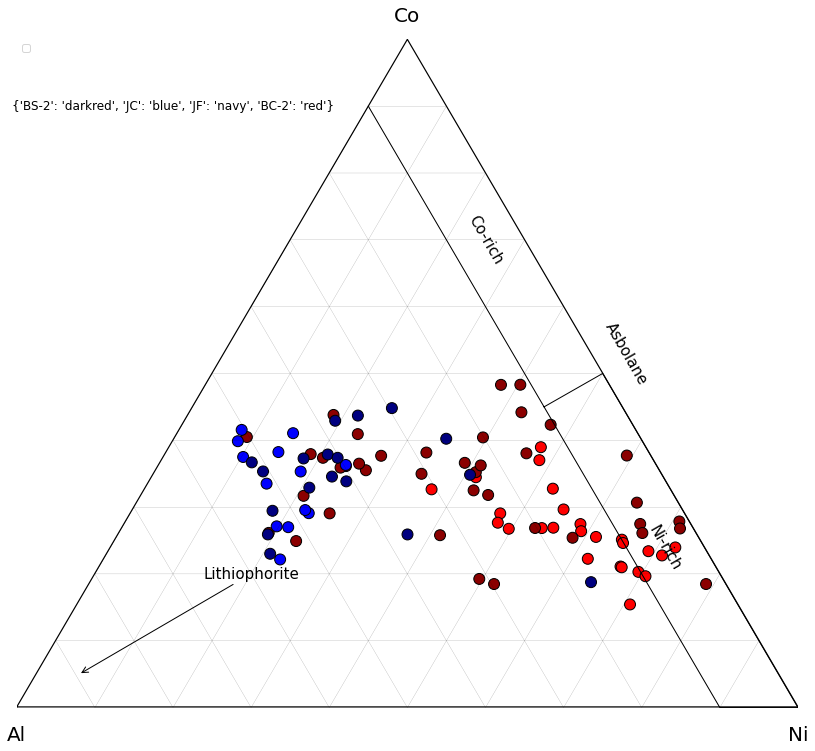

In [ ]:
leg_asb = {'BS-2': 'darkred', 'JC': 'blue', 'JF':'navy', 'BC-2':'red'}

ternary_plot(Al_, Ni, Co, 
             color=None, 
             non_num = BADB_asb['source'], 
             discrete_colors=leg_asb, 
             barvar=None, 
             cmapcolor=None, 
             label=False, 
             grid=True, 
             fields='asbolane',
             frame = (14,14))

0.8780254037844386
save? (y/n)n


<Figure size 1152x885.05 with 0 Axes>

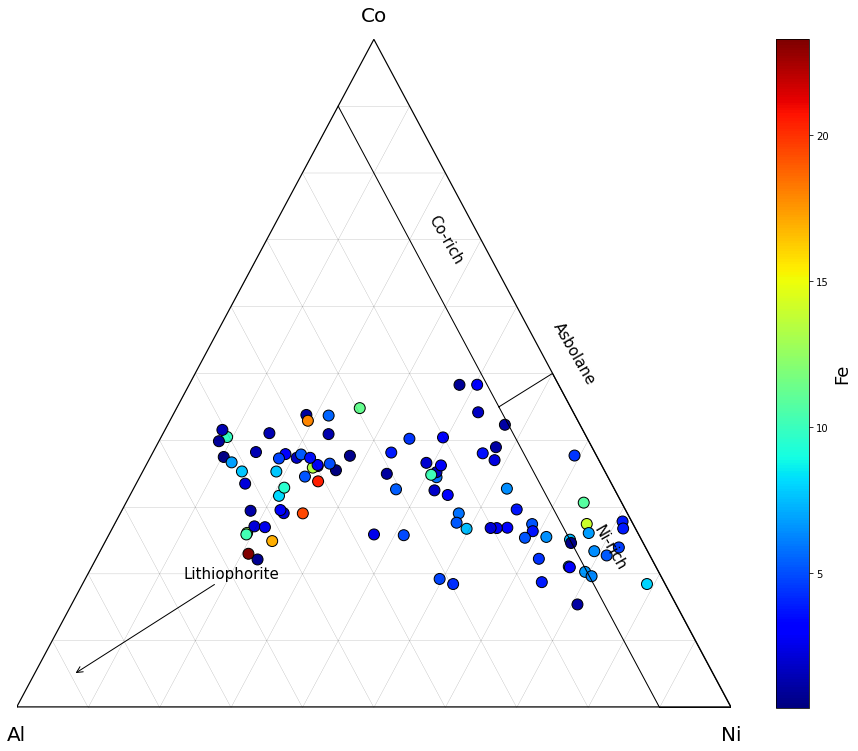

In [ ]:
ternary_plot(Al_, Ni, Co, 
             color=None, 
             non_num = None, 
             discrete_colors=None, 
             barvar=BADB_asb['Fe'], 
             cmapcolor='jet', 
             label=False, 
             grid=True, 
             fields='asbolane',
             frame = (14,14))

In [ ]:
display(BADB_asb)

,source,size,mineral,id,Si,Al,Ca,Ti,Cr,Mn,Fe,Co,Ni,Cu,Zn,Ba,Sum
0,BC-2,0.25x0.18mm,Asbolane-lithiophorite,10,0.810671,6.844873,0.224166,0.0,0.567581,27.441844,5.928850,9.834964,11.849223,0.0,0.0,0.0,64.202281
1,BC-2,0.25x0.18mm,Asbolane-lithiophorite,11,0.851004,6.345130,0.083514,0.0,0.427818,20.355941,5.360418,6.778834,7.631529,0.0,0.0,0.0,51.737442
2,BC-2,0.25x0.18mm,asbolane,16,0.735492,2.154758,0.158018,0.0,0.000000,24.203991,6.674223,4.259671,14.562529,0.0,0.0,0.0,55.605156
3,BC-2,0.25x0.18mm,asbolane,17,0.842905,2.113092,0.140960,0.0,0.000000,24.604785,6.303917,4.285914,15.405966,0.0,0.0,0.0,56.023803
4,BC-2,0.25x0.18mm,asbolane,18,1.409797,2.550828,0.000000,0.0,0.000000,22.828527,6.540929,4.427444,13.996719,0.0,0.0,0.0,54.239159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,JF,0.25x0.18mm,asbolane,b24,0.121646,10.854153,0.000000,0.0,0.000000,26.049956,1.246058,6.084211,3.721268,0.0,0.0,0.0,48.964619
91,JF,0.25x0.18mm,asbolane,b23,0.568955,6.352493,0.000000,0.0,0.000000,16.320333,20.463056,5.259551,3.923889,0.0,0.0,0.0,54.183165
92,JF,0.25x0.18mm,asbolane,b22,0.188223,5.552889,0.000000,0.0,0.000000,19.954339,11.232681,8.414990,4.809166,0.0,0.0,0.0,51.600790
93,JF,0.25x0.18mm,asbolane,b21,0.344049,5.945627,0.000000,0.0,0.000000,18.145970,17.965194,6.756111,3.037404,0.0,0.0,0.0,53.272424


In [ ]:
Mg_, Fe_, Si_ = ternary_coord(BADB)


Empty DataFrame
Columns: [source, size, mineral, id, Mg, Al, Si, Cl, Ti, V, Cr, Mn, Fe, Ni, Zn, Sum]
Index: []
x axis: Mg
y axis: Fe
z axis: Cr
[4.60185749093038, 3.99370128736883, 3.54098049638002, 3.200774438, 2.759698815]
[15.4190693100122, 23.3653974836175, 17.3863987505853, 16.35080489, 17.79011386]
[33.3929277181025, 25.2758260002222, 30.9098342547608, 33.29556183, 36.82280626]


0.8780254037844386
save? (y/n)n


<Figure size 720x632.178 with 0 Axes>

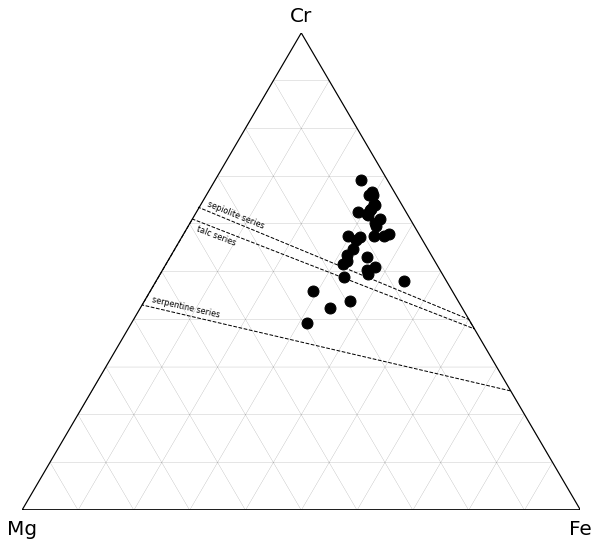

In [ ]:
ternary_plot(Mg_, Fe_, Si_, 
             color='black', 
             non_num = None, 
             discrete_colors=None, 
             barvar=None, 
             cmapcolor=None, 
             label=False, 
             grid=True, 
             fields='mgsilicates')